## Example of generating a equilibrium from GEQDSK ##

- We take the NLED-AUG benchmark as an example. This benchmark is for EP-driven TAE and RSAE in AUG tokamak (Vlad NF 2021). 

- Visit https://pwl.home.ipp.mpg.de/NLED_AUG/data.html and download the geqdsk file https://pwl.home.ipp.mpg.de/NLED_AUG/g031213.00003 to ```examples``` directory

- Download and install FreeQDSK https://github.com/freegs-plasma/FreeQDSK

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gysmc import GEQDSKMagnetConfig
from gysmc import GYSMagnetConfig

### Read the GEQDSK file and set up the coordinates ###
One will need to decide

- To use ```theta``` or ```thetastar``` (straight-field-line angle) 

- COCOs number of the GEQDSK (5 for AUG, only support 2 and 5 currently)

- The ```psi``` value of the computational boundary and the corresponding radial coordinate ```rmax``` for it (should be the same as GYSELA ```rmax```).

- We have enforced the current to be in the positive phi direction as in Vlad paper.

In [2]:
eqdskmc = GEQDSKMagnetConfig('g031213.00003', thetastar=True, cocos=5, psinorm_max=0.9025, rmax=0.95, positive_current=True, verbose=True)

Initialising GEQDSKMagnetConfig from file: g031213.00003
INFO: cocos = 5/15, (R,phi,Z), (r,phi,theta)
INFO: Using thetastar coordinate
INFO: Optimized magnetic axis location: R_axis = 1.665997, Z_axis = 0.065795, Psi_axis = -0.241128
INFO: Original magnetic axis location: R_axis = 1.666000, Z_axis = 0.065803, Psi_axis = -0.241127
INFO: Computational boundary at r=0.9500: s_max=0.9500, psinorm_max=0.9025
INFO: Plasma boundary at r=1.0: s(r=1.0)=1.0000, psinorm(r=1.0)=1.0000
INFO: Geometry in original unit: R_geo = 1.6201, a_geo(at r=1) = 0.4826, Aspect ratio = 3.3569
INFO: Magnetic field in original unit: Bvac_geocentre = 2.2484, B_axis = 2.2081
INFO: Psi1: in original unit psi1 = 0.1595, normalised to Bvac0*a_geo^2 psi1_norm = 0.3045
INFO: B is normalised to Bvac0=2.2484 at Rgeo=1.6201, length to a_geo=0.4826


In [3]:
eqdskmc.signma_phi

-1

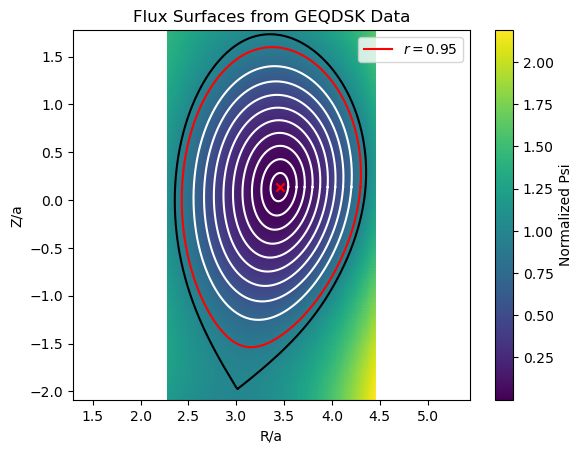

In [4]:
eqdskmc.plot_flux_surfaces(normalised_units=True)

### Run some test to ensure the results are correct ###
- Compare gij and that from finite difference estimation from R,Z(r, theta)
- Compare Contravariant components of current (prescribed by flux functions in GS) and that computed from curl B

INFO: Testing gij comparison with finite difference


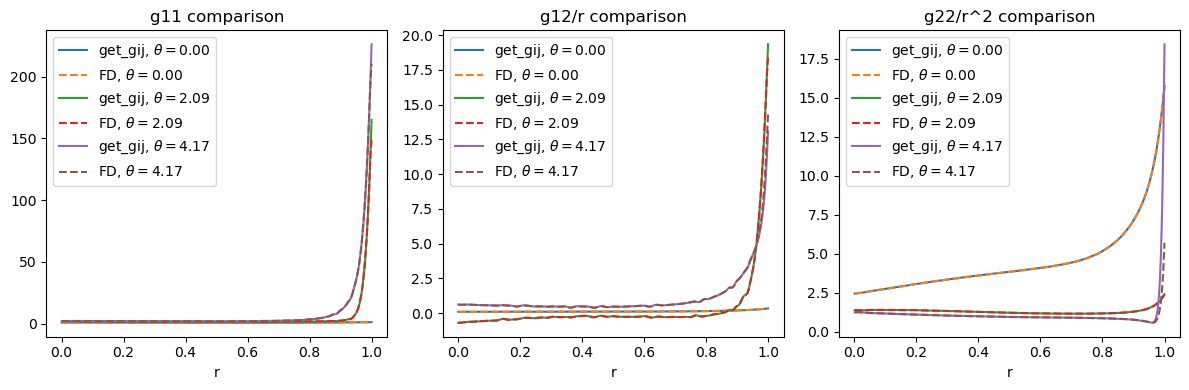

In [5]:
eqdskmc.test_gij2D()

INFO: Testing current comparison with finite difference


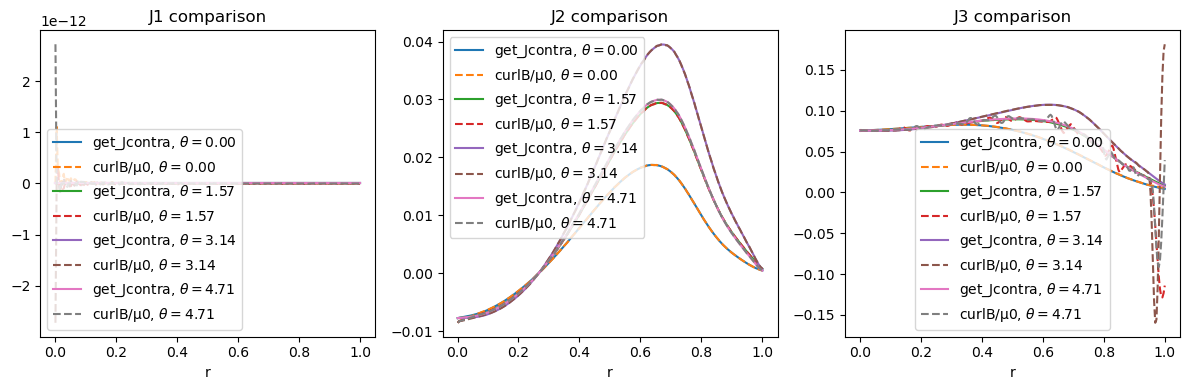

In [6]:
eqdskmc.test_current2D()

### Write to GYSELA magnet_config.h5 ###
```Nr```, ```Ntheta```, ```minor_radius```, ```rmin```, ```rmax```, ```skiphole``` should match that of a GYSELA input file 

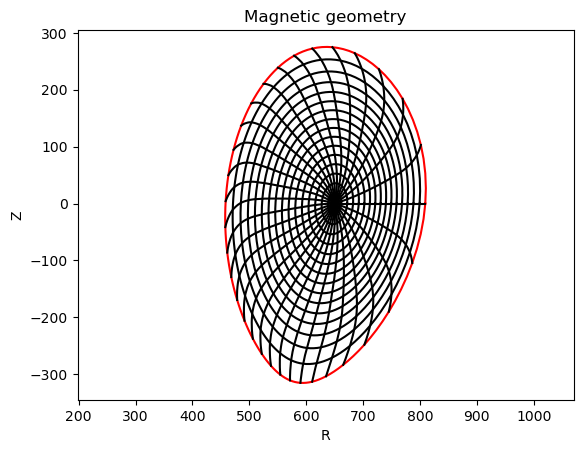

In [9]:
augconfig = GYSMagnetConfig(eqdskmc, Nr=127, Ntheta=128, minor_radius=188.34, rmax=0.95, rmin=0.0, skiphole=True)
augconfig.plot_geometry()
augconfig.to_hdf5('nled_nr127_nt128.h5')

### How to use the generated hdf5 ###

- Copy it to ```gysela``` folder under ```wk/profiles```.

- Set ```magnet_strategy = "EXTERNAL"``` in your ```EQUIL``` namelist.

- Specify the path to the hdf5 file such as ```magnet_config_filename = profiles/magnet_config.h5``` in the ```Variables for radial profile input files``` section.

### Generate the other profiles used for GYSELA ###

- Raw data are found in https://pwl.home.ipp.mpg.de/NLED_AUG/NLED_AUG_benchmark_case.pdf

- Profiles are generated and saved to text files

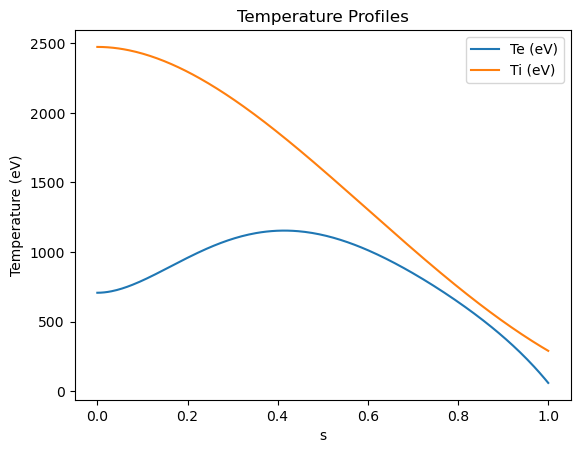

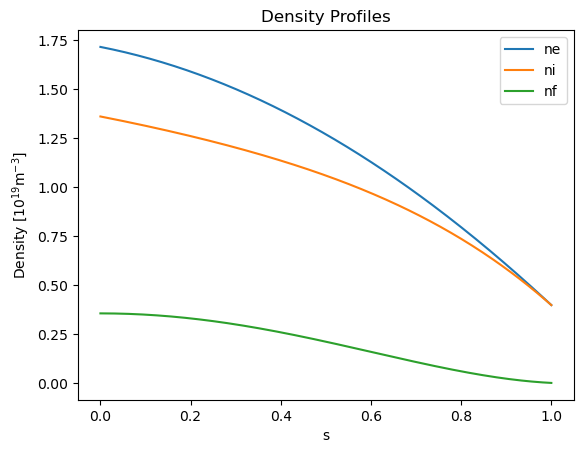

In [11]:
# grid of s
s = np.linspace(0, 1, 257, True)

# Te in eV
# Te(x)=a+b x2+c x3+d x4+e x5
def get_Te(s):
    a = 707.419; b = 11909.8; c = -34439.8; d = 33868.6; e = -11986.6;
    return a + b*s**2 + c*s**3 + d*s**4 + e*s**5

# Ti in eV
# Ti(x)=a+b x2+c x3+d x4+e x5
def get_Ti(s):
    a=2474.1; b=-5128.7;c=3417.9;d=-473.3; e=0
    return a + b*s**2 + c*s**3 + d*s**4 + e*s**5

# Tf in eV
# Tf(x) = a
def get_Tf(s):
    a = 93000
    return a * np.ones_like(s)

# ne in m^-3
# ne(x)=a+b x+c x2+d x4
def get_ne(s):
    a = 1.71587e+19; b = -4.52225e+18; c= -8.85926e+18; d= 1.98778e+17
    return a + b*s + c*s**2 + d*s**4

# nf in m^-3
# nf(x)=a+b x2+c x4
def get_nf(s):
    a = 3.552e+18;b = -6.52986e+18;c= 2.97864e+18
    return a + b*s**2 + c*s**4

def get_ni(s):
    return get_ne(s) - get_nf(s)

plt.figure()
plt.plot(s, get_Te(s), label='Te (eV)')
plt.plot(s, get_Ti(s), label='Ti (eV)')
plt.xlabel('s')
plt.ylabel('Temperature (eV)')
plt.title('Temperature Profiles')
plt.legend()

plt.figure()
plt.plot(s, get_ne(s)*1e-19, label='ne')
plt.plot(s, get_ni(s)*1e-19, label='ni')
plt.plot(s, get_nf(s)*1e-19, label='nf')
plt.xlabel('s')
plt.ylabel(r'Density [$10^{19} \mathrm{m}^{-3}$]')
plt.title('Density Profiles')
plt.legend()

Determine rhostar, aspect ratio, ep fraction, betagys

Tref = Ti(0.5)
nref = ne(0.5)
Bref = Bvac0


In [12]:
Bref =  eqdskmc.Bvac0_real
nref = get_ne(0.5)
Tref = get_Ti(0.5)

print('Bref (T):', Bref)
print('nref at r=0.5 (m^-3):', nref)
print('Tref at r=0.5 (eV):', Tref)

mi = 2 * 1.6726219e-27  # D mass in kg
charge_e = 1.602e-19  # in Coulombs
rho_i = np.sqrt(mi * get_Ti(0.5) * charge_e)/ (charge_e * Bref)  # in meters
print('Te and Ti at r=0.5', get_Te(0.5), get_Ti(0.5))
print('Ion gyroradius at r=0.5 (m):', rho_i)
print('1/rhostar at r=0.5:', eqdskmc.ageo_real / rho_i)  # minor radius in meters
print('aspect ratio R0/a:', eqdskmc.Rgeo_real / eqdskmc.ageo_real)

mu0 = 4e-7 * np.pi
betagys = mu0 * nref * Tref * charge_e / (Bref**2)
print('betaGYS:', betagys)

nffraction = get_nf(0.5) / get_ne(0.5)
nifraction = get_ni(0.5) / get_ne(0.5)
print('Fast ion fraction at r=0.5:', nffraction)
print('Thermal ion fraction at r=0.5:', nifraction)

Bref (T): 2.248384300033479
nref at r=0.5 (m^-3): 1.2695183625e+19
Tref at r=0.5 (eV): 1589.58125
Te and Ti at r=0.5 1122.1002499999993 1589.58125
Ion gyroradius at r=0.5 (m): 0.0025624385125579264
1/rhostar at r=0.5: 188.34269315757328
aspect ratio R0/a: 3.356893185842148
betaGYS: 0.0008036241992165232
Fast ion fraction at r=0.5: 0.16586605300086787
Thermal ion fraction at r=0.5: 0.8341339469991321


In [15]:
get_nf(0)

3.552e+18

In [9]:
# write profiles to file, double column: r, value, one profile per file
with open('Te_nled.dat', 'w') as f:
    for i in range(len(s)):
        f.write(f"{s[i]:.6f} {get_Te(s[i])/Tref:.6e}\n")

with open('Ti_nled.dat', 'w') as f:
    for i in range(len(s)):
        f.write(f"{s[i]:.6f} {get_Ti(s[i])/Tref:.6e}\n")

with open('Tf_nled.dat', 'w') as f:
    for i in range(len(s)):
        f.write(f"{s[i]:.6f} {get_Tf(s[i])/Tref:.6e}\n")

with open('ni_nled.dat', 'w') as f:
    for i in range(len(s)):
        f.write(f"{s[i]:.6f} {get_ni(s[i])/nref/nifraction:.6e}\n")

with open('nf_nled.dat', 'w') as f:
    for i in range(len(s)):
        f.write(f"{s[i]:.6f} {get_nf(s[i])/nref/nffraction:.6e}\n")

